# Zillow Clustering Project

In [1]:
import numpy as np
import pandas as pd
""
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import wrangle_zillow as wr
import preprocessing as pr

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

# Acquire
The DataFrame below contains all fields from the `properties_2017` table as well as the descriptive fields from the appropriate tables in the `zillow` database. The data is filtered to only include properties that have a `latitude` and `longitude` value.

In [2]:
df = wr.get_zillow_data()
print(f"Our DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Our DataFrame has 77580 rows and 68 columns.


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


> What kind of data types are we working with? How many null values are in each column?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77580 entries, 0 to 77579
Data columns (total 68 columns):
id                              77580 non-null int64
parcelid                        77580 non-null int64
airconditioningtypeid           25007 non-null float64
architecturalstyletypeid        207 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77580 non-null float64
bedroomcnt                      77580 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49810 non-null float64
calculatedbathnbr               76964 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6037 non-null float64
calculatedfinishedsquarefeet    77379 non-null float64
finishedsquarefeet12            73924 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50          

> **We will need to address the abudance of null values and change some of the data types before we can begin our analysis.**

> Let's take a look at some of the summary statistics before we being preparing our data.

In [4]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.758000e+04,7.758000e+04,25007.000000,207.000000,50.000000,77580.000000,77580.000000,15.000000,49810.000000,76964.000000,614.0,6037.000000,77379.000000,73924.000000,42.000000,3027.000000,6037.000000,386.000000,77580.000000,8289.000000,76964.000000,25520.000000,25520.000000,1539.0,49572.000000,7.758000e+04,7.758000e+04,6.932200e+04,16174.0,869.000000,465.0,1074.0,15079.0,77580.000000,7.758000e+04,76108.000000,77580.000000,30974.000000,77530.000000,77580.000000,50.0,10106.000000,223.000000,50704.000000,2393.000000,70.000000,77310.000000,17599.000000,172.0,7.746500e+04,7.757900e+04,77580.0,7.757800e+04,77575.000000,2900.000000,7.733300e+04,77580.000000
mean,1.495404e+06,1.300828e+07,1.812013,7.386473,679.720000,2.298492,3.053222,3.933333,6.533728,2.316388,66.0,1366.165314,1784.925923,1760.274945,1388.761905,2354.491245,1381.388935,2082.500000,6048.813998,1.191217,2.250104,1.815282,350.047061,1.0,3.921811,3.400837e+07,-1.182037e+08,2.997309e+04,1.0,517.930955,1.0,1.0,1.0,261.824465,6.049124e+07,33684.165817,2534.522235,187725.110544,96586.691539,1.476257,7.0,1.009598,6.040359,1.110307,305.460928,216.385714,1968.611396,1.434286,1.0,1.892796e+05,4.901476e+05,2016.0,3.011500e+05,5995.927626,14.088276,6.049667e+13,0.016800
std,8.609700e+05,3.519376e+06,2.965768,2.728030,689.703546,0.996726,1.140472,0.258199,1.722082,0.979684,0.0,670.701336,954.247864,934.349898,122.220874,1186.985442,725.792665,1240.382784,20.747162,0.490980,0.966486,0.588340,261.646070,0.0,3.594770,2.652856e+05,3.594078e+05,1.233042e+05,0.0,156.569664,0.0,0.0,0.0,5.141564,2.058953e+05,47212.464556,801.445328,165045.086058,3793.527616,2.823673,0.0,0.118572,0.556035,1.169955,238.735241,190.177514,23.793037,0.544515,0.0,2.304095e+05,6.537942e+05,0.0,4.927219e+05,7628.816490,2.181281,1.533329e+12,0.170739
min,3.490000e+02,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,7.521430e+05,1.153820e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,1.0,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,1.0,8.417100e+04,2.068990e+05,2016.0,8.529325e+04,2712.650000,14.000000,6.037311e+13,-0.024310
50%,1.498256e+06,1.253056e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000

> Finally, let's plot the distributions of the data to help us identify outliers that need to be addressed.

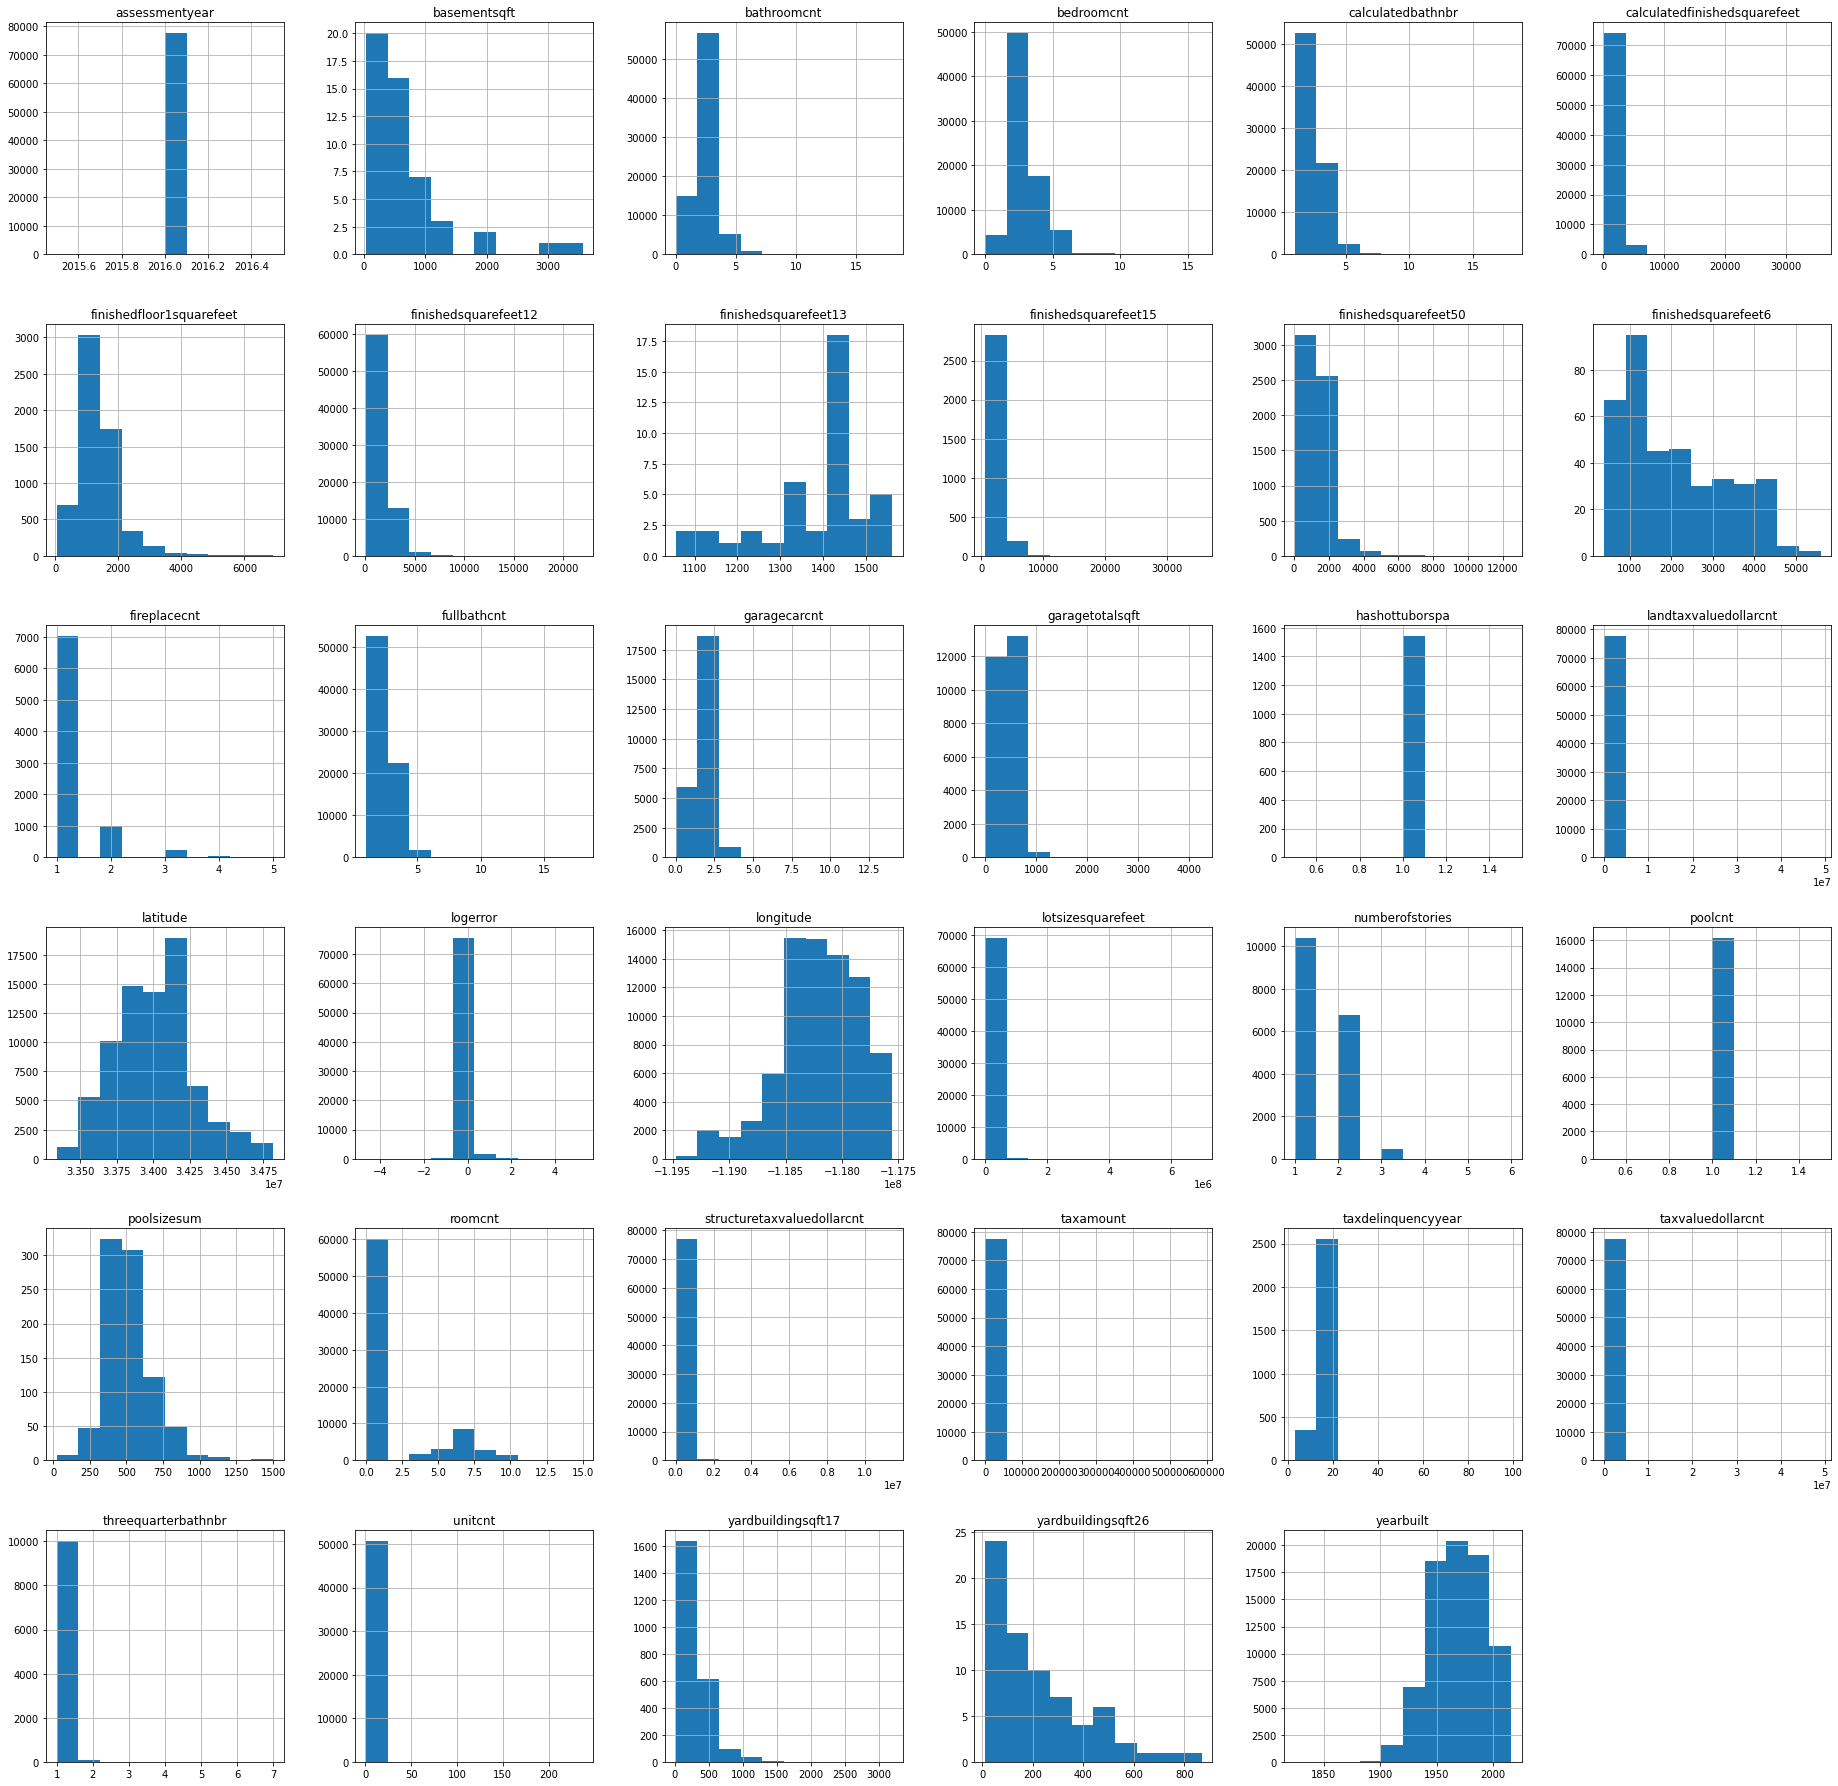

In [5]:
# let's drop the numeric id fields as they will not serve us in our hunt for outliers.
df.drop(columns=["id", "parcelid", "airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid", "buildingqualitytypeid", "decktypeid", "fips", "heatingorsystemtypeid", "pooltypeid10", "pooltypeid2", "pooltypeid7", "propertylandusetypeid", "rawcensustractandblock", "regionidcity", "regionidcounty", "regionidneighborhood", "regionidzip", "storytypeid", "typeconstructiontypeid", "fireplaceflag", "censustractandblock"]).hist(figsize=(32, 32))
plt.show()

> **Now that we have a general idea of what our data looks like, let's move into preparation.**

---
# Prepare

In [6]:
# df = wr.get_single_unit_properties(df)
# df = wr.remove_columns(df, cols_to_remove=["id", "propertylandusetypeid", "heatingorsystemtypeid", "propertyzoningdesc", "finishedsquarefeet12"])
# df = wr.handle_missing_values(df)
# df = wr.impute_missing_values(df)
# df = wr.remove_rows(df, cols_to_mask=["structuretaxvaluedollarcnt", "taxamount", "censustractandblock", "regionidzip"])
# df = wr.create_new_variables(df)
# df.reset_index(inplace=True)
# df.drop(columns="index", inplace=True)
# df.info()

In [7]:
# df

In [8]:
# wr.convert_dtypes(df, columns=["fips", "regionidcity", "regionidcounty", "regionidzip"], dtype="object")
# df.hist(figsize=(16, 16))
# plt.show()

In [9]:
# df.tax_rate.sort_values(ascending=False).head(20)

In [10]:
# q1, q3 = df.tax_rate.quantile([.25, .75])
# q1, q3

In [11]:
# iqr = q3 - q1
# iqr

In [12]:
# upper_bound = q3 + (3 * iqr)
# upper_bound

In [13]:
# wr.get_upper_outliers(df.tax_rate, 3).sort_values(ascending=False).head(2149)

In [14]:
# df.loc[45416, :].tax_rate

In [15]:
# df.loc[16768, :].tax_rate

In [16]:
# more_than_three_times = lambda x: max([x - upper_bound, 0])
# more_than_three_times

In [17]:
# more_than_three_times(df.loc[45416, :].tax_rate).round(6)

In [18]:
# more_than_three_times(df.loc[16768, :].tax_rate)

In [19]:
# lower_bound = q1 - (3 * iqr)
# lower_bound

In [20]:
# wr.get_lower_outliers(df.tax_rate, 3).sort_values().head(66)

In [21]:
# df.loc[34753, :].tax_rate

In [22]:
# df.loc[5712, :].tax_rate

In [23]:
# wr.get_lower_outliers(df.tax_rate, 3).sort_values()[65]

In [24]:
# df.tax_rate.sort_values(ascending=False).tail(67)

In [25]:
# lower_bound

In [26]:
# min([df.loc[5712, :].tax_rate - lower_bound, 0])

## Explanation of `prep_zillow` function
The function does the following:
1. Removes any properties that cannot be interpreted as single unit/single family homes
2. Removes fields that will not add any value to our analysis (i.e., identifier fields and those with redundant information)
3. Drops columns and indices that are missing more than 60% of their respective data
4. Imputes missing values remaining after the function in number 3 has been called (excluding the `regionidcity` field)
5. Drops indices deemed unworthy of imputation either because there are too few values missing to put in the effort of imputing or imputation is not a practical means of handling the missing data (e.g., `censustractandblock`)
6. Creates new `county` and `tax_rate` variables
7. Resets the index of the DataFrame
8. Drops former index column
9. Handles outliers

## Preprocessing
9. Splits prepared DataFrame into `train`, `validate`, and `test`
10. KNN imputes the regionidcity for `train`, `validate`, and `test`
11. Scales all appropriate numeric fields for `train`, `validate`, and `test`
12. Returns the `imputer`, `scaler`, `train`, `validate`, and `test` variables

In [27]:
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,NaN,NaN,1286.0,1286.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34245368.0,-118282383.0,47405.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARE40,6.037101e+07,12447.0,3101.0,27328.0,96284.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,0.020615,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77576,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,NaN,1612.0,1612.0,1612.0,NaN,NaN,1612.0,NaN,6111.0,1.0,2.0,2.0,560.0,NaN,NaN,34300140.0,-118706327.0,

In [28]:
df = wr.prep_zillow(df)

In [29]:
df.taxvaluedollarcnt.max()

1872424.0

In [30]:
col_list = []
for col in df.columns:
    if col.endswith("_outliers"):
        if len(df[col].value_counts()) < 3:
            col_list.append(col)
df.drop(columns=col_list, inplace=True)

In [31]:
df.shape

(44768, 31)

In [32]:
imputer, scaler, train, validate, test = pr.split_impute_scale(df)
imputer

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [33]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [34]:
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (26860, 31)
validate shape = (8954, 31)
    test shape = (8954, 31)


In [35]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate
7087,0.008712,0.6,0.333333,0.636364,0.6,0.522165,6037,0.6,0.565118,0.606294,0.425179,0100,0.001178,12447,3101,96008,0.000000,0.0,0.430657,0.696794,0.361819,0.0,0.155282,0.396783,0.000002,0.594238,2017-02-26,Central,Single Family Residential,Los Angeles County,0.477314
33075,0.024432,0.3,0.500000,0.454545,0.3,0.439455,6059,0.2,0.103840,0.918736,0.304955,122,0.296872,17686,1286,96961,0.666667,0.0,0.700730,0.294626,0.164664,0.0,0.085796,0.193285,0.000519,0.598979,2017-07-14,None,Single Family Residential,Orange County,0.527775
35427,0.012888,0.2,0.333333,0.454545,0.2,0.224909,6037,0.2,0.362500,0.556033,0.327198,0100,0.007435,54722,3101,96161,0.000000,0.0,0.591241,0.179050,0.355638,0.0,0.394432,0.360944,0.000013,0.606580,2017-07-27,Central,Single Family Residential,Los Angeles County,0.411598
7886,0.023362,0.2,0.666667,0.454545,0.2,0.274803,6059,0.2,0.271350,0.816511,0.348273,122,0.297302,47568,1286,97004,0.666667,0.0,0.613139,0.108010,0.285909,0.0,0.335843,0.296881,0.000520,0.602900,2017-03-02,None,Single Family Residential,Orange County,0.428522
33404,0.011850,0.2,0.333333,0.272727,0.2,0.206102,6037,0.2,0.336733,0.693832,0.315187,0100,0.006402,46298,3101,96247,0.000000,0.0,0.554745,0.163887,0.171555,0.0,0.157402,0.181603,0.000011,0.599040,2017-07-18,Central,Single Family Residential,Los Angeles County,0.438077


In [36]:
train.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [37]:
validate.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [38]:
test.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26860 entries, 7087 to 43258
Data columns (total 31 columns):
parcelid                        26860 non-null float64
bathroomcnt                     26860 non-null float64
bedroomcnt                      26860 non-null float64
buildingqualitytypeid           26860 non-null float64
calculatedbathnbr               26860 non-null float64
calculatedfinishedsquarefeet    26860 non-null float64
fips                            26860 non-null object
fullbathcnt                     26860 non-null float64
latitude                        26860 non-null float64
longitude                       26860 non-null float64
lotsizesquarefeet               26860 non-null float64
propertycountylandusecode       26860 non-null object
rawcensustractandblock          26860 non-null float64
regionidcity                    26860 non-null object
regionidcounty                  26860 non-null object
regionidzip                     26860 non-null object
roomcnt      

In [40]:
train.describe()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,tax_rate
count,26860.000000,26860.000000,26860.000000,26860.000000,26860.000000,26860.000000,26860.000000,26860.000000,26860.000000,26860.000000,26860.000000,26860.000000,26860.0,26860.000000,26860.000000,26860.000000,26860.0,26860.000000,26860.000000,26860.000000,26860.000000,26860.000000
mean,0.015032,0.236046,0.374473,0.459852,0.236050,0.310549,0.223313,0.482954,0.654777,0.378082,0.170652,0.164600,0.0,0.614290,0.234381,0.220531,0.0,0.188713,0.237612,0.000336,0.596589,0.503073
std,0.014177,0.164890,0.146786,0.113863,0.164883,0.136244,0.161040,0.190042,0.194574,0.156610,0.281672,0.262983,0.0,0.163092,0.170998,0.163463,0.0,0.165030,0.164188,0.006120,0.021423,0.141609
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005746,0.200000,0.333333,0.454545,0.200000,0.211092,0.200000,0.347628,0.543558,0.289940,0.004047,0.000000,0.0,0.525547,0.114485,0.100043,0.0,0.059152,0.121235,0.000007,0.591399,0.418841
50%,0.012848,0.200000,0.333333,0.454545,0.200000,0.278641,0.200000,0.477606,0.678740,0.353890,0.006752,0.000000,0.0,0.598540,0.186915,0.189073,0.0,0.151363,0.205797,0.000012,0.595238,0.466601
75%,0.022527,0.400000,0.500000,0.454545,0.400000,0.381884,0.400000,0.608153,0.798081,0.433076,0.296872,0.416667,0.0,0.722628,0.302963,0.297483,0.0,0.269833,0.310181,0.000519,0.599258,0.549912
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


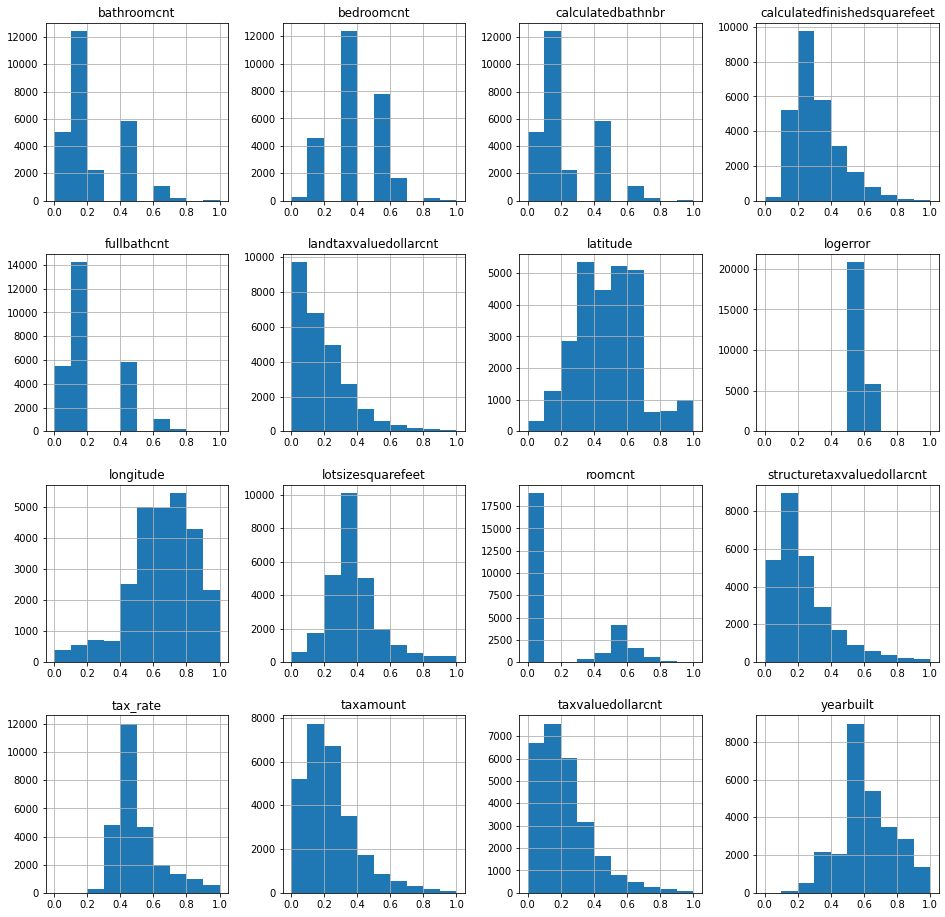

In [41]:
train = wr.convert_dtypes(train, columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"], dtype="object")
train.hist(figsize=(16, 16))
plt.show()

# Explore

In [42]:
# sns.pairplot(data=train)

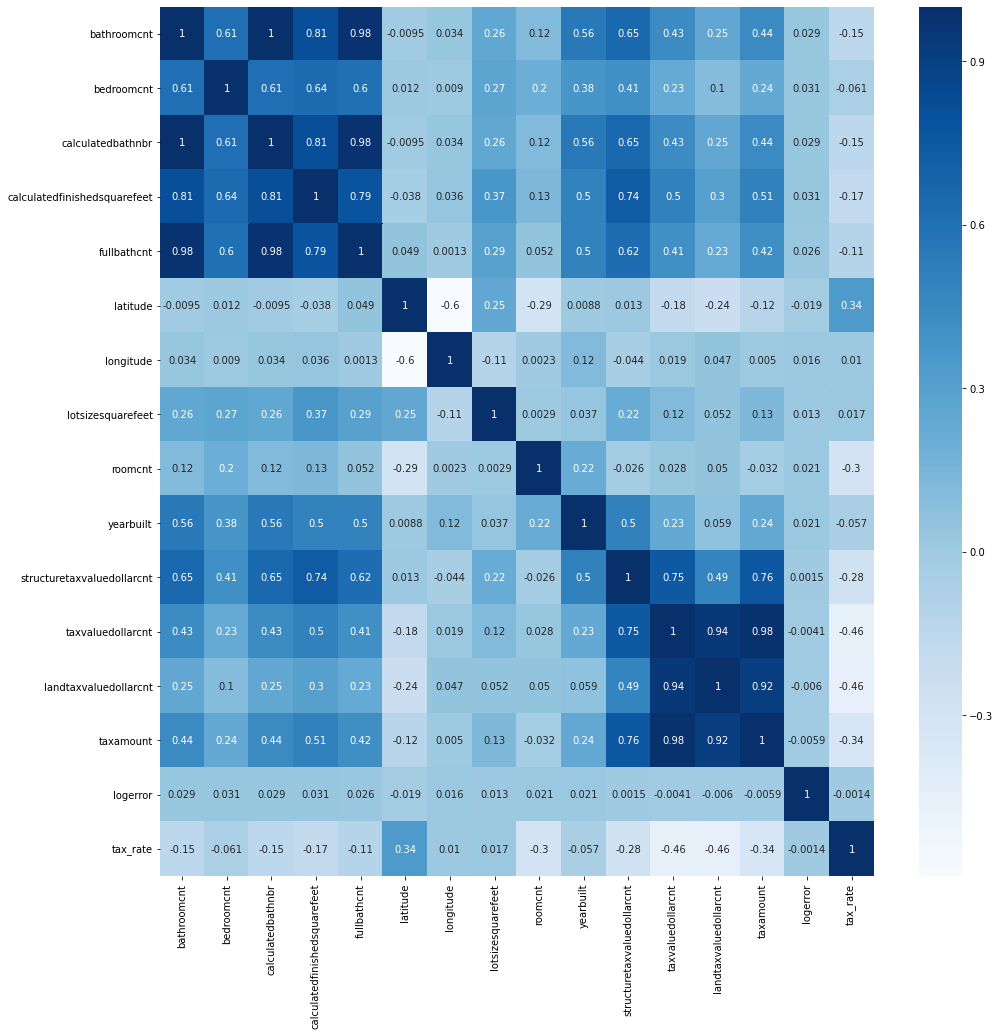

In [43]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True, cmap="Blues")
plt.show()

## Cluster the Target Variable
Objectives:
1. Reduce the noise of the continuous variable so that trends in the data are more easily identifiable
2. Compare clusters with other variables through visualizations or hypothesis testing

In [44]:
X = train[["logerror"]]
X.shape

(26860, 1)

In [45]:
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

In [46]:
high_drop = scoreatpercentile(X, 99.9)
low_drop = scoreatpercentile(X, .1)
low_drop, high_drop

(0.4698209443942797, 0.8855589906337433)

In [47]:
train = train[(train.logerror > low_drop) & (train.logerror < high_drop)]

In [48]:
X = train[["logerror"]]


In [49]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([0, 0, 0, ..., 3, 5, 0], dtype=int32)

In [50]:
def get_inertia(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

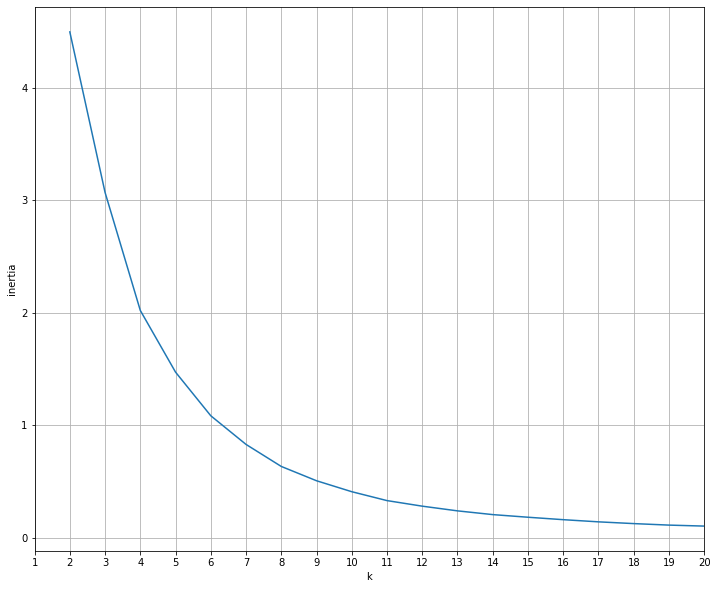

In [51]:
plt.figure(figsize=(12, 10))
pd.Series({k: get_inertia(k) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [52]:
# according to the elbow method above 7 clusters also seems reasonable
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["cluster_target"] = kmeans.predict(X)

In [53]:
train["cluster"]= "cluster_" + train.cluster_target.astype(str)
train.cluster.head()

7087     cluster_0
33075    cluster_6
35427    cluster_6
7886     cluster_6
33404    cluster_6
Name: cluster, dtype: object

In [54]:
kmeans.cluster_centers_

array([[0.59368304],
       [0.68500847],
       [0.62834736],
       [0.5792649 ],
       [0.53597007],
       [0.81462122],
       [0.6032372 ]])

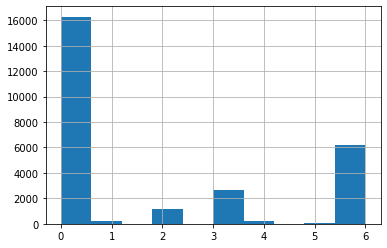

In [55]:
train.cluster_target.hist()

In [56]:
train.cluster_target.value_counts()

0    16281
6     6213
3     2666
2     1168
4      233
1      201
5       44
Name: cluster_target, dtype: int64

#### target variable cluster insights
- logerror clustering has huge value_counts range
- using score at percentile we can see that clusters still have huge range in size

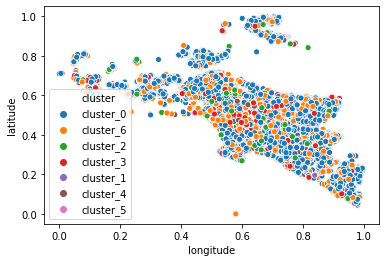

In [57]:
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster')

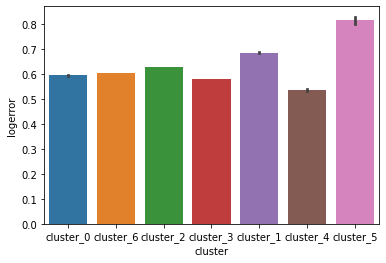

In [58]:
sns.barplot(x='cluster', y='logerror', data=train)

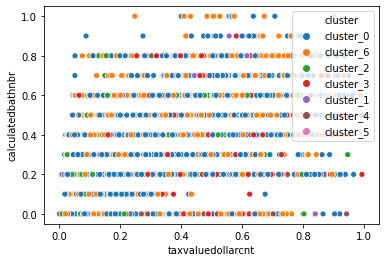

In [59]:
sns.scatterplot(x='taxvaluedollarcnt', y='calculatedbathnbr', data=train, hue='cluster')

In [60]:
train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'heatingorsystemdesc', 'propertylandusedesc',
       'county', 'tax_rate', 'cluster_target', 'cluster'],
      dtype='object')

# Feature engineering:
- tax rate
- buildingqualitytypeid    
- landtaxvaluecount
- lotsizesquarefeet
- calculatedbathnbr
- ~~roomcnt~~

## Yard_size

In [61]:
train['yard_size'] = train.lotsizesquarefeet - train.calculatedfinishedsquarefeet

In [62]:
X = train[['yard_size']]

In [63]:
def get_inertia(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

In [64]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

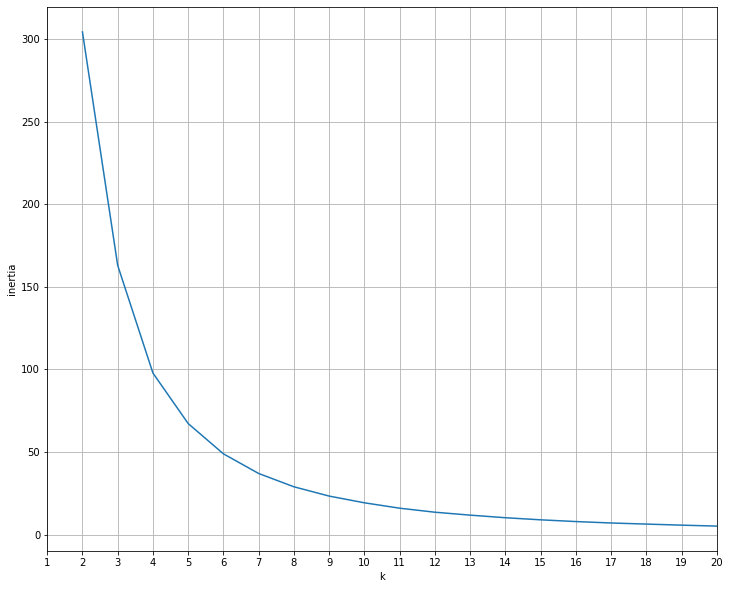

In [65]:
plt.figure(figsize=(12, 10))
pd.Series({k: get_inertia(k) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [66]:
len(X), train.shape[0]

(26806, 26806)

In [67]:
# according to the elbow method above 7 clusters also seems reasonable
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["cluster_yard"] = kmeans.predict(X)

In [68]:
train["cluster_yard"]= "cluster_" + train.cluster_target.astype(str)
train.cluster.head()

7087     cluster_0
33075    cluster_6
35427    cluster_6
7886     cluster_6
33404    cluster_6
Name: cluster, dtype: object

In [69]:
kmeans.cluster_centers_

array([[-0.01449842],
       [ 0.08379346],
       [ 0.29369293],
       [-0.28182387],
       [ 0.17185117],
       [-0.14009666],
       [ 0.50437671]])

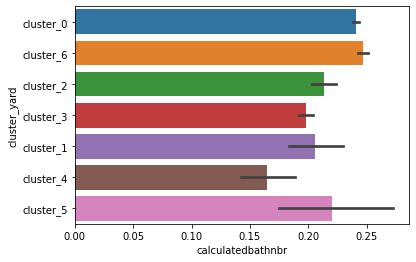

In [70]:
sns.barplot(x='calculatedbathnbr', y='cluster_yard', data=train)

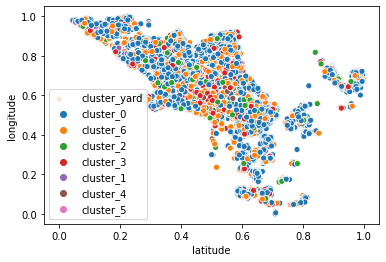

In [71]:
sns.scatterplot(x='latitude', y='longitude', data=train, hue='cluster_yard')

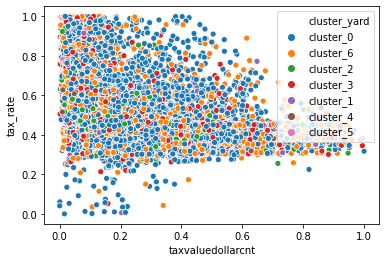

In [72]:
sns.scatterplot(x='taxvaluedollarcnt', y='tax_rate', data=train, hue='cluster_yard')

## Price per square foot
- Can't do the calculation on scaled data because 0 is in scaling for calculatedfinishedsquarefeet

In [73]:
df['price_per_sq_ft'] = df.taxvaluedollarcnt / df.calculatedfinishedsquarefeet

In [74]:
X = df[['price_per_sq_ft']]

In [75]:
def get_inertia(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

In [76]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([1, 1, 2, ..., 0, 1, 1], dtype=int32)

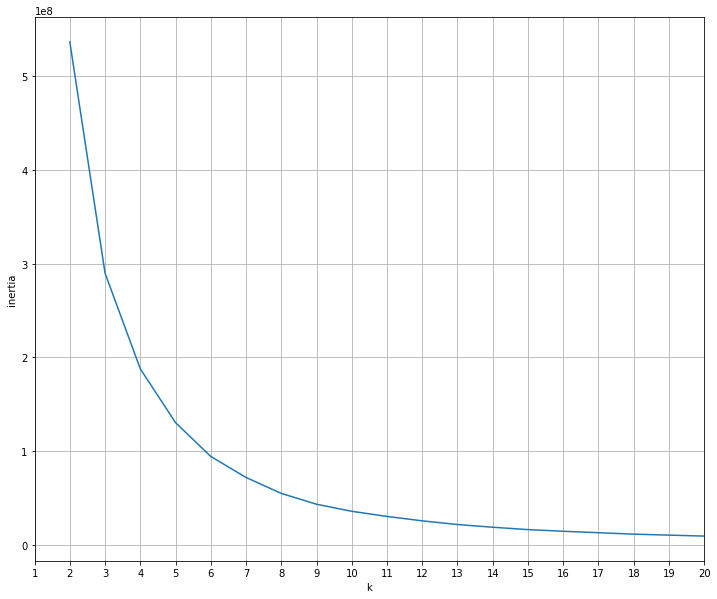

In [77]:
plt.figure(figsize=(12, 10))
pd.Series({k: get_inertia(k) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [78]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)
df["cluster_feature"] = kmeans.predict(X)

In [79]:
df["cluster_ppsq"]= "cluster_" + df.cluster_feature.astype(str)
df.cluster_ppsq.head()

0    cluster_0
1    cluster_0
2    cluster_4
3    cluster_7
4    cluster_0
Name: cluster_ppsq, dtype: object

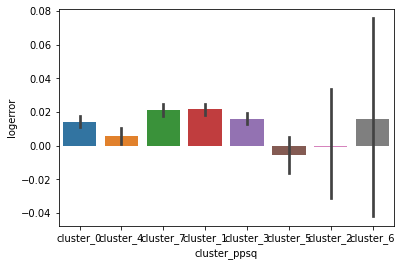

In [80]:
sns.barplot(y='logerror', x='cluster_ppsq', data=df)

In [81]:
train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'heatingorsystemdesc', 'propertylandusedesc',
       'county', 'tax_rate', 'cluster_target', 'cluster', 'yard_size',
       'cluster_yard'],
      dtype='object')

### Drop roomcnt as a feature
- Too many zero values
- Unsure if bathrooms count as rooms

### Drop transaction_date

In [82]:
# list_room =[]
# if train.roomcnt != 0:
#     list_room.append(train.roomcnt - train.bedroomcnt)

# list_room.max()

(df[df.roomcnt > 0].roomcnt - df[df.roomcnt > 0].bedroomcnt).describe()

count    13211.000000
mean         3.334872
std          0.982455
min         -3.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
dtype: float64

In [83]:
(df[df.roomcnt > 0].roomcnt - df[df.roomcnt > 0].bedroomcnt).nsmallest(40)

26211   -3.0
4155    -2.0
9004    -2.0
14029   -2.0
17512   -2.0
30190   -2.0
34658   -2.0
2191    -1.0
2551    -1.0
3370    -1.0
22017   -1.0
23004   -1.0
23829   -1.0
27963   -1.0
32394   -1.0
35708   -1.0
36713   -1.0
37799   -1.0
38206   -1.0
43227   -1.0
117      0.0
367      0.0
2393     0.0
2714     0.0
2743     0.0
3403     0.0
3878     0.0
8943     0.0
9439     0.0
9837     0.0
11251    0.0
11337    0.0
11535    0.0
12859    0.0
13382    0.0
13517    0.0
14613    0.0
15535    0.0
16418    0.0
16464    0.0
dtype: float64

In [84]:
train.roomcnt.value_counts()

0.000000    18950
0.500000     2169
0.583333     1982
0.666667     1562
0.416667     1071
0.750000      578
0.333333      286
0.833333      136
0.250000       33
0.916667       25
1.000000        7
0.166667        6
0.083333        1
Name: roomcnt, dtype: int64

In [85]:
mask = (train.taxvaluedollarcnt - train.taxvaluedollarcnt_upper_outliers == 0 )
train[mask]

AttributeError: 'DataFrame' object has no attribute 'taxvaluedollarcnt_upper_outliers'

In [ ]:
k = 3
outlier_columns = ['tax_rate', 'lotsizesquarefeet']
def get_thresholds(df=df, columns=outlier_columns, k=3):
    list_upper = []
    list_lower = []
    for col in outlier_columns:
        lower_25 = (df[col].quantile(.25))
        upper_75 = (df[col].quantile(.75))
        IQR = iqr(df[col])*k
        upper_threshold = upper_75 + IQR
        if df[col].min() >= 0:
            lower_threshold = max([lower_25 - IQR, 0])
        else:
            lower_threshold = lower_25 - IQR
        list_upper.append(upper_threshold)
        list_lower.append(lower_threshold)
    return list_upper, list_lower

In [ ]:
list_upper, list_lower = get_thresholds()
list_upper[1]
outlier_columns

In [ ]:
def replace_outliers(df=df, outliers_columns=outlier_columns, list_upper=list_upper, list_lower=list_lower):
    for i in range(0, len(outlier_columns)):
        col = outlier_columns[i]
        rebuild_col = []
        for x in df[col]:
            if x > list_upper[i]:
                rebuild_col.append(list_upper[i])
            elif x < list_lower[i]:
                rebuild_col.append(list_upper[i])
            elif x > list_lower[i] and x < list_upper[i]:
                rebuild_col.append(x)
            else:
                rebuild_col.append(-50000000000)
        df[col] = rebuild_col
    return df  

In [ ]:
df = replace_outliers(df)
df.tax_rate.max() == list_upper[0]

In [ ]:
# for x in df.lotsizesquarefeet:
#     if x > upper_threshold:
#         df.lotsizesquarefeet = df.lotsizesquarefeet.replace(list_upper[1])
#     elif x < lower_threshold:
#         x = (list_lower[1])

In [ ]:
# testing = [if x > list_upper[1] list_upper[1] for x in df.lotsizesquarefeet ]
rebuild_col = []
for x in df.lotsizesquarefeet:
    if x > list_upper[1]:
        rebuild_col.append(list_upper[1])
    else:
        rebuild_col.append(x)
df.lotsizesquarefeet = rebuild_col

In [ ]:
new_df = wr.get_zillow_data()

In [ ]:
new_df.shape

In [ ]:
list_to_drop = []
for col in new_df.columns:
    if new_df[col].isna().mean() > .80:
        list_to_drop.append(col)
new_df.drop(columns=list_to_drop, inplace=True)
new_df.shape

In [ ]:
neighborhood_df = new_df[new_df.regionidneighborhood > 0]

In [ ]:
neighborhood_df.isnull().mean()

In [88]:
df.transactiondate.value_counts()

2017-06-30    675
2017-04-28    537
2017-05-31    483
2017-07-28    463
2017-08-31    450
             ... 
2017-06-11      1
2017-07-08      1
2017-05-13      1
2017-08-12      1
2017-03-11      1
Name: transactiondate, Length: 253, dtype: int64

# Conclusions

### What did we do?
- Acquire data from zillow database
- Prep data by:
    - Dropping rows
    - Dropping columns
    - imputing missing data
    - scaling continuous variables
    - **determined and handled outliers**
        - spent a lot of time going between zsore and **iqr** 
- Exploration:
    - Created new features:
        - `tax_rate`
        - `yard_size`
        - `price_per_square_foot`
    - Vizualizing clusters
        - it is difficult to choose which features what features

### What did you learn?
- logerror is not clustered by location, housing value
- modeling with clusters
    - for each cluster different features were chosen using RFE


### What willl you do next?
- clustering by date to see if locations or sale price fit into clusters.
    - Are housing prices affected by hot months?
    - certain neighborhoods more kid friendly

- subsetting data with nulls
    - Upon initial review neighborhood had excellent clustered data
    - However, lots of missing values, try to model just non-null neighborhood data
    
- building more functions
    - working on modeling functions that loop through clusters that fill prediction dataframe
    - determining outliers by `percentileofscore` and `iqr`
    

### What are considerations/ gotchas
- The best time to scale is right before the clustering
- How do you build
- zscore
- Had an easy time manipulating data in dataframes, harder to record it
- when modeling clusters, should you use the clustered features or not
    - **NO** - already using data in clustering don't want to use again
    - **YES** - best way to see the different affect on each cluster
        - We think yes is the answer
- what is a reasonable percentage of outliers
    - we found 10% in a couple different places 
    - 3 std above mean accounts for 99.7% of data on normal distribution

